In [27]:
import torch
from torch import nn
from torch.nn import functional as F
from dataHandler.dataset import MHDProjDataset,LogNormalTransform
import tqdm
import matplotlib.pyplot as plt
import os

In [28]:
MODEL_ID='VAE_1.7'

SOURCE_DIR='/mnt/home/dheurtel/ceph/00_exploration_data/toy'

SAMPLE_FOLDER='/mnt/home/dheurtel/ceph/20_samples/ddpm_initial/'  #For periodic samples
CKPT_FOLDER='/mnt/home/dheurtel/ceph/10_checkpoints/VAE_FID/' #For checkpoints and losses



SIZE=256
SAMPLE_BATCH_SIZE=8
BATCH_SIZE=64
RESULT_SAMPLE_SIZE=256


SAMPLE_STEP_EPOCH=100

NUM_EPOCHS=500

LR=1e-3

BETA=1

In [29]:
os.listdir(CKPT_FOLDER)

['VAE_1.0', 'VAE_1.6', 'VAE_1.4', 'VAE_1.7', 'VAE_1.5', 'VAE_1.1']

In [30]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
dataset=MHDProjDataset(SOURCE_DIR,transforms=LogNormalTransform(),random_rotate=True,sorted=False)

In [32]:
dataloader=torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [33]:
class NormalizedConvolution(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding='same', activation=None, normalize=True):
        super(NormalizedConvolution, self).__init__()
        self.ln = nn.BatchNorm2d(in_c)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        return out
    
def TinyBlock(size, in_c, out_c):
    return nn.Sequential(NormalizedConvolution((in_c, size, size), in_c, out_c), 
                         NormalizedConvolution((out_c, size, size), out_c, out_c), 
                         NormalizedConvolution((out_c, size, size), out_c, out_c))

def TinyUp(size, in_c):
    return nn.Sequential(NormalizedConvolution((in_c, size, size), in_c, in_c//2), 
                         NormalizedConvolution((in_c//2, size, size), in_c//2, in_c//4), 
                         NormalizedConvolution((in_c//4, size, size), in_c//4, in_c//4))

In [34]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=512, z_dim=256):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            TinyBlock(SIZE, image_channels, 8),
            nn.Conv2d(8, 8, 4, 4, 1),
            TinyBlock(SIZE//4,8,16),
            nn.Conv2d(16, 16, 4, 4, 1),
            TinyBlock(SIZE//16, 16, 32),
        )

        
        self.decoder = nn.Sequential(
            TinyBlock(SIZE//16, 32,16),
            nn.ConvTranspose2d(16, 16, 4, 4, 0),
            TinyBlock(SIZE//4, 16, 8),
            nn.ConvTranspose2d(8, 8, 4, 4, 0),
            TinyBlock(SIZE, 8, 4),
            nn.Conv2d(4, image_channels,1, 1, 'same')
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    
    # def forward(self, x):
    #     h = self.encoder(x)
    #     #z = self.fc1(self.fc3(h))
    #     z=self.fc(h).unsqueeze(-1).unsqueeze(-1)
    #     return self.decoder(z)
    def forward(self, x):
        h = self.encoder(x)
        #z, mu, logvar = self.bottleneck(h)
        #z = self.fc3(z).unsqueeze(-1).unsqueeze(-1)
        return self.decoder(h)#, mu, logvar

In [36]:
def loss_fn(recon_x,x,mu,logvar):
    MSE=F.mse_loss(recon_x,x)
    KLD= -0.5*torch.mean(1+logvar-mu.pow(2)-logvar.exp())
    return MSE+BETA*KLD,MSE,KLD

def loss_fn2(recon_x,x):
    MSE=F.mse_loss(recon_x,x)
    return MSE

In [37]:
model = VAE(image_channels=1).to(device)

In [38]:
#ckpt = torch.load(os.path.join(CKPT_FOLDER, MODEL_ID, 'ckpt.pt'))
#model.load_state_dict(ckpt['vae'])

In [100]:
epochs=1

In [101]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 

scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.9)

In [102]:
progress_bar = tqdm.tqdm(total=epochs)

for epoch in range(epochs):
    
    model.train()
    avg_loss,avg_mse,avg_kld=0,0,0
    tot_step=0

    for step,images in enumerate(dataloader):
        images=images.unsqueeze(1).to(device)
        #recon_images, mu, logvar = model(images)
        #loss, mse, kld = loss_fn(recon_images, images, mu, logvar)
        

        latent=model.encoder(images)
        recon_images=model.decoder(latent)
        
        loss=loss_fn2(recon_images,images)+F.mse_loss(latent, torch.zeros(latent.shape).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        

        #logs = {"_loss": loss.detach().item() }
        #progress_bar.set_postfix(**logs)
        avg_loss+=loss
        #avg_kld+=kld
        #avg_mse+=mse
        
        tot_step+=1
    scheduler.step()
    avg_loss=avg_loss/tot_step
    #avg_kld=avg_kld/tot_step
    #avg_mse=avg_mse/tot_step

    progress_bar.update(1)
    #logs = {"_loss": loss.detach().item(), "mse" : mse.detach().item(), "kld": kld.detach().item() }
    logs = {"_loss": avg_loss.detach().item() }
    progress_bar.set_postfix(**logs)
    
progress_bar.close()

100%|██████████| 1/1 [01:08<00:00, 68.79s/it, _loss=0.0161]


In [103]:
_, batch= next(enumerate(dataloader))

In [104]:
recons_x=model(batch.unsqueeze(1).to(device))

In [105]:
recons_x[0].shape

torch.Size([1, 256, 256])

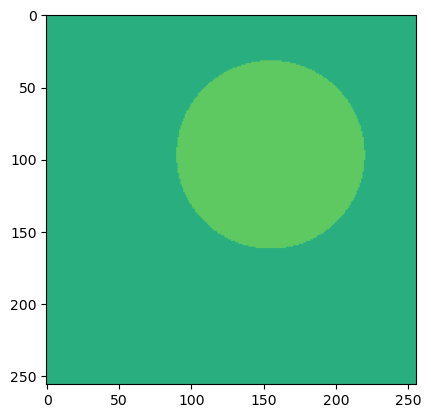

In [106]:
plt.imshow(batch[0],vmin=-5, vmax=5)

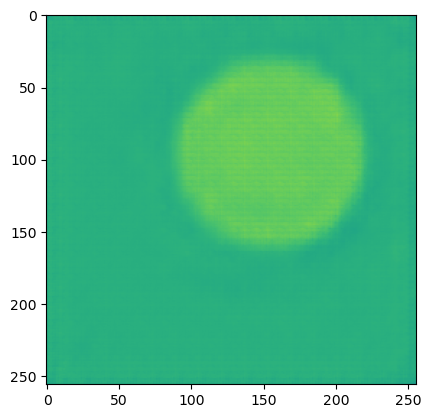

In [107]:
plt.imshow(recons_x[0][0].cpu().detach(),vmin=-5, vmax=5)

In [49]:
os.mkdir(CKPT_FOLDER+MODEL_ID)

FileExistsError: [Errno 17] File exists: '/mnt/home/dheurtel/ceph/10_checkpoints/VAE_FID/VAE_1.7'

In [50]:
ckpt= {'vae': model.state_dict()}
torch.save(ckpt,os.path.join(CKPT_FOLDER,MODEL_ID,'ckpt.pt'))

In [121]:
generator=model.decoder
encoder=model.encoder

In [122]:
latent=encoder(batch.unsqueeze(1).to(device))
#latent=torch.randn(latent.shape)

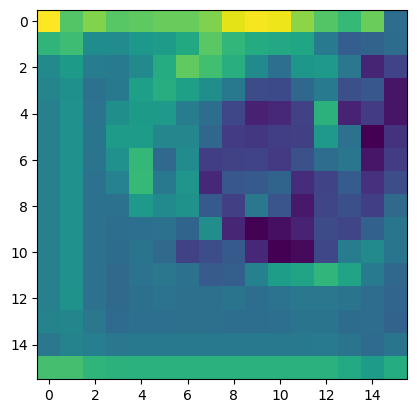

In [123]:
plt.imshow(latent[0][1].cpu().detach())

In [155]:
latent_prime=latent+100.0*torch.randn(latent.shape).to(device)

In [156]:
generated_prime=generator(latent_prime)

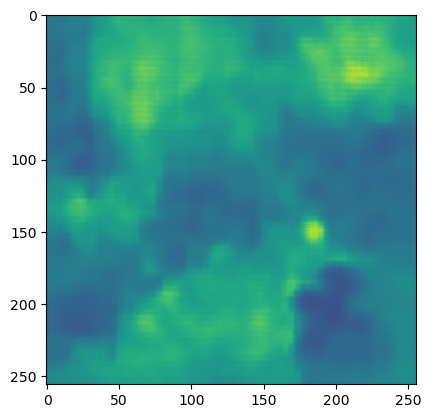

In [157]:
plt.imshow(generated_prime[0][0].detach().cpu(),vmin=-5, vmax=5)

In [114]:
test=batch

In [115]:
latent=encoder(test.unsqueeze(0).unsqueeze(0).to(device))

In [116]:
decoded=generator(latent)

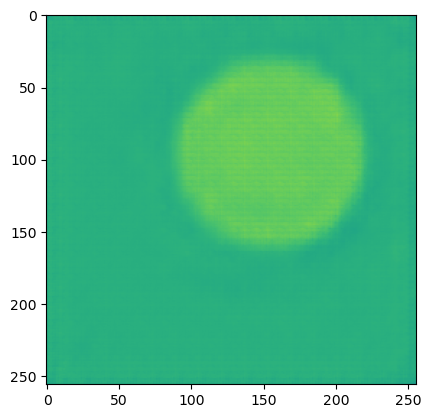

In [120]:
plt.imshow(model.decoder(model.encoder(batch.unsqueeze(1).to(device))).cpu().detach()[0][0],vmin=-5, vmax=5)